In [424]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F

In [425]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n/project/data/'

path = '/content/drive/My Drive/{}'.format(FOLDERNAME)

# import sys
# sys.path.append()
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Intialize Variables

In [502]:
# Root directory for dataset
dataroot = path + 'cfp-dataset/'

# Number of workers for dataloader
# workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.00016

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [503]:
# !unzip '/content/drive/My Drive/cs231n/project/data/cfp-dataset.zip' -d '/content/drive/My Drive/cs231n/project/data/celebs'

# Dataset Setup

In [504]:

# img_path = dataroot + 'Data/Images/'
# for i in range(2, 501):
# # for i in range(1, 501):
#     folder_num = "".join(['0'] * (3 - len(str(i)))) + str(i)
#     f_src = img_path + folder_num + "/frontal/"
#     f_dst = dataroot + 'frontals/'

#     p_src = img_path + folder_num + "/profile/"
#     p_dst = dataroot + 'profiles/'
#     # for f in os.listdir(f_src):
#     for j in range(1, 5):
#         old_fn = '0{}.jpg'.format(j)
#         new_fn_f = str(i) + '_f_' + old_fn
#         os.rename(f_src + old_fn, f_dst + new_fn_f)
#         new_fn_p = str(i) + '_p_' + old_fn
#         os.rename(p_src + old_fn, p_dst + new_fn_p)
    



In [505]:
import os
from torchvision.io import read_image, ImageReadMode

class PFImageDataset(Dataset):
    def __init__(self, profile_path, frontal_path, transform=None):
        self.profile_path = profile_path
        self.frontal_path = frontal_path
        self.transform = transform

    def __len__(self):
        return 4 * 500

    def __getitem__(self, idx):
        p_img_file = '{}_p_0{}.jpg'.format(idx // 4 + 1, (idx - 1) % 4 + 1)
        p_img_path = os.path.join(self.profile_path, p_img_file)

        f_img_file = '{}_f_0{}.jpg'.format(idx // 4 + 1, (idx - 1) % 4 + 1)
        f_img_path = os.path.join(self.frontal_path, f_img_file)
        img_mode = ImageReadMode(1)
        image = read_image(p_img_path, mode=img_mode.RGB)
        label = read_image(f_img_path, mode=img_mode.RGB)
        if self.transform is not None:
            image = self.transform(image)
            label = self.transform(label)
        return image, label

In [506]:
dataset_path = path + 'dataset/'
print(dataset_path)

profile_path = dataset_path + 'profiles/'
frontal_path = dataset_path + 'frontals/'

dataset = PFImageDataset(profile_path,
                         frontal_path,
                         transform=transforms.Compose([
                             transforms.ToPILImage(),
                             transforms.Resize(image_size),
                             transforms.CenterCrop(image_size),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,),(0.5,)),
                            #  transforms.ToTensor(),
                            #  transforms.Normalize((0.5, 0.5), (0.5, 0.5)),
                            #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                         ]))

# dataset = dset.ImageFolder(root=dataset_path,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))

# Create the dataloader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                          shuffle=True, num_workers=workers)

# Decide which device we want to run on
# device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


## Weight Initialization:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



/content/drive/My Drive/cs231n/project/data/dataset/


In [507]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                        #  shuffle=True
                                         )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                            #   shuffle=True
                                              )


In [508]:
# img = train_features[0]
# label = train_labels[0]
# plt.imshow(img.reshape((64, 64, 3)))
# plt.show()
# plt.imshow(label.reshape((64, 64, 3)))
# plt.show()

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64, 3, 64, 64])


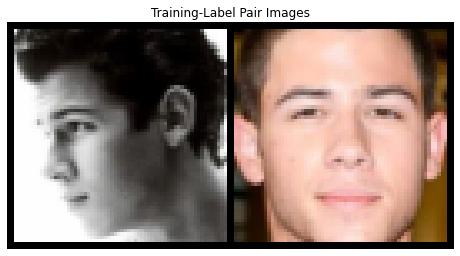

In [509]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training-Label Pair Images")
plt.imshow(np.transpose(vutils.make_grid([train_features[0].to(device), train_labels[0].to(device)], padding=2, normalize=True).cpu(), (1,2,0)))

# Test Generator Class

In [510]:
# class Generator(nn.Module):
#     def __init__(self, ):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#             # nn.BatchNorm2d(ngf * 8),
#             # nn.ReLU(True),
#             # input is Z, going into a convolution
#             nn.Conv2d(nc, image_size, 4, 2, 1),
#             nn.Conv2d(ngf, out_channels, kernel_size, stride=stride, padding=padding),
#             nn.BatchNorm2d(out_channels, momentum=0.1, eps=1e-5),

#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self.main(input)

# Generator Class

In [511]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
    padding=padding)
def conv_n(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, 
        stride=stride, padding=padding), nn.BatchNorm2d(out_channels, 
        momentum=0.1, eps=1e-5),)
def tconv(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, 
    padding=padding, output_padding=output_padding)
    
def tconv_n(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0):
    return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
        stride=stride, padding=padding, output_padding=output_padding), 
        nn.BatchNorm2d(out_channels, momentum=0.1, eps=1e-5),)

In [512]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n1 = conv(nc, ngf, 4, 2, 1) 
        self.n2 = conv_n(ngf, ngf*2, 4, 2, 1)
        self.n3 = conv_n(ngf*2, ngf*4, 4, 2, 1)
        self.n4 = conv_n(ngf*4, ngf*8, 4, 2, 1)
        self.n5 = conv(ngf*8, ngf*8, 4, 2, 1)
        self.n6 = conv(ngf*8, ngf*8, 4, 2, 1)

        self.m9 = tconv_n(ngf*8, ngf*8, 4, 2, 1)
        self.m0 = tconv_n(ngf*8*2, ngf*8, 4, 2, 1)
        self.m1 = tconv_n(ngf*8*2, ngf*4, 4, 2, 1)
        # self.m0 = tconv_n(ngf*8, ngf*8, 4, 2, 1)
        # self.m1 = tconv_n(ngf*8, ngf*4, 4, 2, 1)
        self.m2 = tconv_n(ngf*4*2, ngf*2, 4, 2, 1)
        self.m3 = tconv_n(ngf*2*2, ngf*1, 4, 2, 1)
        self.m4 = tconv(ngf*1*2, nc, 4, 2, 1)

        # self.n1 = conv(nc, ngf, 4, 2, 1) 
        # self.n2 = conv_n(ngf, ngf*2, 4, 2, 1)
        # self.n3 = conv_n(ngf*2, ngf*4, 4, 2, 1)
        # self.n4 = conv_n(ngf*4, ngf*8, 4, 2, 1)
        # self.n5 = conv_n(ngf*8, ngf*8, 4, 2, 1)
        # self.n6 = conv_n(ngf*8, ngf*8, 4, 2, 1)
        # self.n7 = conv_n(ngf*8, ngf*8, 4, 2, 1)
        # self.n8 = conv(ngf*8, ngf*8, 4, 2, 1)
        # self.m1 = tconv_n(ngf*8, ngf*8, 4, 2, 1)
        # self.m2 = tconv_n(ngf*8*2, ngf*8, 4, 2, 1)
        # self.m3 = tconv_n(ngf*8*2, ngf*8, 4, 2, 1)
        # self.m4 = tconv_n(ngf*8*2, ngf*8, 4, 2, 1)
        # self.m5 = tconv_n(ngf*8*2, ngf*4, 4, 2, 1)
        # self.m6 = tconv_n(ngf*4*2, ngf*2, 4, 2, 1)
        # self.m7 = tconv_n(ngf*2*2, ngf*1, 4, 2, 1)
        # self.m8 = tconv(ngf*1*2, nc, 4, 2, 1)

        self.tanh = nn.Tanh()
        
    def forward(self,x):
        n1 = self.n1(x)
        n2 = self.n2(F.leaky_relu(n1, 0.2))
        n3 = self.n3(F.leaky_relu(n2, 0.2))
        n4 = self.n4(F.leaky_relu(n3, 0.2))

        n5 = self.n5(F.leaky_relu(n4, 0.2))
        n6 = self.n6(F.leaky_relu(n5, 0.2))

        m9 = torch.cat([self.m9(F.relu(n6)), n5], 1)
        m0 = torch.cat([self.m0(F.relu(m9)), n4], 1)
        
        m1 = torch.cat([self.m1(F.relu(m0)), n3], 1)
        # m1 = torch.cat([self.m1(F.relu(n4)), n3], 1)
        m2 = torch.cat([self.m2(F.relu(m1)), n2], 1)
        m3 = torch.cat([self.m3(F.relu(m2)), n1], 1)
        m4 = self.m4(F.relu(m3))

        # n1 = self.n1(x)
        # n2 = self.n2(F.leaky_relu(n1, 0.2))
        # n3 = self.n3(F.leaky_relu(n2, 0.2))
        # n4 = self.n4(F.leaky_relu(n3, 0.2))
        # n5 = self.n5(F.leaky_relu(n4, 0.2))
        # n6 = self.n6(F.leaky_relu(n5, 0.2))
        # n7 = self.n7(F.leaky_relu(n6, 0.2))
        # n8 = self.n8(F.leaky_relu(n7, 0.2))
        # m1 = torch.cat([F.dropout(self.m1(F.relu(n8)), 0.5, training=True), n7], 1)
        # m2 = torch.cat([F.dropout(self.m2(F.relu(m1)), 0.5, training=True), n6], 1)
        # m3 = torch.cat([F.dropout(self.m3(F.relu(m2)), 0.5, training=True), n5], 1)
        # m4 = torch.cat([self.m4(F.relu(m3)), n4], 1)
        # m5 = torch.cat([self.m5(F.relu(m4)), n3], 1)
        # m6 = torch.cat([self.m6(F.relu(m5)), n2], 1)
        # m7 = torch.cat([self.m7(F.relu(m6)), n1], 1)
        # m8 = self.m8(F.relu(m7))

        return self.tanh(m4)

In [513]:
# Create the generator
netG = Generator().to(device)

# Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (n1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (n2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (n3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (n4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (n5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (n6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (m9): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# Test Discriminator Class

In [514]:
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

# Discriminator Class

In [515]:
dim_d = 64

class Discriminator(nn.Module):
    def __init__(self): 
        super(Discriminator, self).__init__()
        self.c1 = conv(nc * 2, dim_d, 4, 2, 1) 
        self.c2 = conv_n(dim_d, dim_d*2, 4, 2, 1)
        self.c3 = conv_n(dim_d*2, dim_d*4, 4, 2, 1)
        self.c4 = conv_n(dim_d*4, dim_d*8, 4, 1, 1)
        self.c5 = conv(dim_d*8, 1, 4, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        xy=torch.cat([x,y],dim=1)
        xy=F.leaky_relu(self.c1(xy), 0.2)
        xy=F.leaky_relu(self.c2(xy), 0.2)
        xy=F.leaky_relu(self.c3(xy), 0.2)
        xy=F.leaky_relu(self.c4(xy), 0.2)
        xy=self.c5(xy)

        return self.sigmoid(xy)

In [516]:
# Create the Discriminator
netD = Discriminator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (c1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (c3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (c4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (c5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (sigmoid): Sigmoid()
)


# Loss Functions

In [517]:

def split(img, n): 
    return img[:,:,:,:n], img[:,:,:,n:] 

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

BCE = nn.BCELoss() #binary cross-entropy
L1 = nn.L1Loss()

fix_con = next(iter(test_dataloader))
print(len(fix_con))
fix_X, fix_y = fix_con
print(type(fix_X))
fix_X = fix_X.to(device)
fix_y = fix_y.to(device)

2
<class 'torch.Tensor'>


# Training

In [ ]:
img_list = []
netG_losses = []
netD_losses = []
netG_GAN_losses = []
netG_L1_losses = []
num_epochs = 200
iter_per_plot = 100

iters = 0
L1_lambda = 100.0

test_num = 7


for epoch in tqdm(range(num_epochs)):
# for epoch in range(num_epochs):
    # for i, (data, _) in tqdm(enumerate(train_dataloader)):
    for i, (x, y) in enumerate(train_dataloader):
        # print(data.size())
        # print(y.size())
        size = x[0].shape[0]
        x, y = x.to(device), y.to(device)

        # netD
        netD.zero_grad()

        #real_patch
        r_patch = netD(y, x)
        r_masks = torch.ones(r_patch.shape).to(device)
        f_masks = torch.zeros(r_patch.shape).to(device)
        r_gan_loss=BCE(r_patch, r_masks)
        
        fake = netG(x)
        # print(fake.shape)

        #fake_patch
        f_patch = netD(fake.detach(),x)
        f_gan_loss=BCE(f_patch,f_masks)
        netD_loss = r_gan_loss + f_gan_loss
        netD_loss.backward()
        optimizerD.step()
        # netG
        netG.zero_grad()
        f_patch = netD(fake,x)
        f_gan_loss=BCE(f_patch,r_masks)
        L1_loss = L1(fake,y)
        netG_loss = f_gan_loss + L1_lambda*L1_loss
        netG_loss.backward()
    
        optimizerG.step()
        iters += 1
        if (iters + 1) % iter_per_plot == 0 :
            
            print('Epoch [{}/{}], Step [{}/{}], netD_loss: {:.4f}, netG_loss: {:.4f},netD(real): {:.2f}, netD(fake):{:.2f}, netG_loss_gan:{:.4f}, netG_loss_L1:{:.4f}'.format(epoch, num_epochs, i+1, len(train_dataloader), netD_loss.item(), netG_loss.item(), r_patch.mean(), f_patch.mean(), f_gan_loss.item(), L1_loss.item()))
            
            netG_losses.append(netG_loss.item())
            netD_losses.append(netD_loss.item())
            netG_GAN_losses.append(f_gan_loss.item())
            netG_L1_losses.append(L1_loss.item())
            with torch.no_grad():
                netG.eval()
                fake = netG(fix_X).detach().cpu()
                netG.train()
            figs=plt.figure(figsize=(10,10))
            plt.subplot(1,3,1)
            plt.axis("off")
            plt.title("input image")
            plt.imshow(np.transpose(vutils.make_grid(fix_X, nrow=1, padding=5, 
            normalize=True).cpu(), (1,2,0)))
            plt.subplot(1,3,2)
            plt.axis("off")
            plt.title("netGerated image")
            plt.imshow(np.transpose(vutils.make_grid(fake, nrow=1, padding=5, 
            normalize=True).cpu(), (1,2,0)))
      
            plt.subplot(1,3,3)
            plt.axis("off")
            plt.title("ground truth")
            plt.imshow(np.transpose(vutils.make_grid(fix_y, nrow=1, padding=5, 
            normalize=True).cpu(), (1,2,0)))
      
            plt.savefig(os.path.join(path, 'logs/test' + str(test_num) + '/Test'+"-"+str(epoch) +".png"))
            plt.close()
            img_list.append(figs)

  2%|▏         | 3/200 [00:28<30:55,  9.42s/it]

Epoch [3/200], Step [24/25], netD_loss: 1.3956, netG_loss: 27.9048,netD(real): 0.78, netD(fake):0.06, netG_loss_gan:3.0516, netG_loss_L1:0.2485


  4%|▎         | 7/200 [01:05<30:03,  9.34s/it]

Epoch [7/200], Step [24/25], netD_loss: 1.0689, netG_loss: 22.3145,netD(real): 0.79, netD(fake):0.13, netG_loss_gan:2.2251, netG_loss_L1:0.2009


  6%|▌         | 11/200 [01:42<29:05,  9.24s/it]

Epoch [11/200], Step [24/25], netD_loss: 1.0875, netG_loss: 18.2571,netD(real): 0.70, netD(fake):0.27, netG_loss_gan:1.4376, netG_loss_L1:0.1682


  8%|▊         | 15/200 [02:19<28:33,  9.26s/it]

Epoch [15/200], Step [24/25], netD_loss: 1.1442, netG_loss: 16.6348,netD(real): 0.67, netD(fake):0.31, netG_loss_gan:1.2642, netG_loss_L1:0.1537


 10%|▉         | 19/200 [02:57<28:00,  9.28s/it]

Epoch [19/200], Step [24/25], netD_loss: 1.0828, netG_loss: 15.5059,netD(real): 0.72, netD(fake):0.23, netG_loss_gan:1.5935, netG_loss_L1:0.1391


 12%|█▏        | 23/200 [03:34<27:58,  9.48s/it]

Epoch [23/200], Step [24/25], netD_loss: 1.0816, netG_loss: 13.9989,netD(real): 0.56, netD(fake):0.42, netG_loss_gan:0.9351, netG_loss_L1:0.1306


 14%|█▎        | 27/200 [04:11<26:43,  9.27s/it]

Epoch [27/200], Step [24/25], netD_loss: 1.1337, netG_loss: 12.8485,netD(real): 0.48, netD(fake):0.43, netG_loss_gan:0.9060, netG_loss_L1:0.1194


 16%|█▌        | 31/200 [04:48<25:58,  9.22s/it]

Epoch [31/200], Step [24/25], netD_loss: 1.1657, netG_loss: 12.1972,netD(real): 0.45, netD(fake):0.41, netG_loss_gan:0.9314, netG_loss_L1:0.1127


 18%|█▊        | 35/200 [05:25<25:22,  9.23s/it]

Epoch [35/200], Step [24/25], netD_loss: 1.0578, netG_loss: 11.5392,netD(real): 0.51, netD(fake):0.39, netG_loss_gan:1.0287, netG_loss_L1:0.1051


 20%|█▉        | 39/200 [06:03<24:58,  9.31s/it]

Epoch [39/200], Step [24/25], netD_loss: 1.1455, netG_loss: 11.5419,netD(real): 0.58, netD(fake):0.34, netG_loss_gan:1.1563, netG_loss_L1:0.1039


 22%|██▏       | 43/200 [06:40<24:16,  9.28s/it]

Epoch [43/200], Step [24/25], netD_loss: 1.1536, netG_loss: 11.1151,netD(real): 0.62, netD(fake):0.32, netG_loss_gan:1.2129, netG_loss_L1:0.0990


 24%|██▎       | 47/200 [07:17<23:32,  9.23s/it]

Epoch [47/200], Step [24/25], netD_loss: 1.1069, netG_loss: 10.5152,netD(real): 0.62, netD(fake):0.36, netG_loss_gan:1.0619, netG_loss_L1:0.0945


 26%|██▌       | 51/200 [07:54<22:55,  9.23s/it]

Epoch [51/200], Step [24/25], netD_loss: 1.1625, netG_loss: 10.5133,netD(real): 0.65, netD(fake):0.35, netG_loss_gan:1.1171, netG_loss_L1:0.0940


 28%|██▊       | 55/200 [08:31<22:09,  9.17s/it]

Epoch [55/200], Step [24/25], netD_loss: 1.2208, netG_loss: 10.0042,netD(real): 0.72, netD(fake):0.31, netG_loss_gan:1.2258, netG_loss_L1:0.0878


 30%|██▉       | 59/200 [09:08<21:23,  9.10s/it]

Epoch [59/200], Step [24/25], netD_loss: 1.1399, netG_loss: 9.1349,netD(real): 0.60, netD(fake):0.57, netG_loss_gan:0.6054, netG_loss_L1:0.0853


 32%|███▏      | 63/200 [09:45<21:00,  9.20s/it]

Epoch [63/200], Step [24/25], netD_loss: 1.1299, netG_loss: 8.5606,netD(real): 0.44, netD(fake):0.66, netG_loss_gan:0.4344, netG_loss_L1:0.0813


 34%|███▎      | 67/200 [10:22<20:21,  9.18s/it]

Epoch [67/200], Step [24/25], netD_loss: 1.1553, netG_loss: 8.6970,netD(real): 0.40, netD(fake):0.62, netG_loss_gan:0.5042, netG_loss_L1:0.0819


 36%|███▌      | 71/200 [10:58<19:42,  9.16s/it]

Epoch [71/200], Step [24/25], netD_loss: 1.1022, netG_loss: 8.5328,netD(real): 0.42, netD(fake):0.55, netG_loss_gan:0.6330, netG_loss_L1:0.0790


 38%|███▊      | 75/200 [11:36<19:21,  9.29s/it]

Epoch [75/200], Step [24/25], netD_loss: 1.0733, netG_loss: 8.3222,netD(real): 0.45, netD(fake):0.47, netG_loss_gan:0.8001, netG_loss_L1:0.0752


 40%|███▉      | 79/200 [12:13<18:45,  9.30s/it]

Epoch [79/200], Step [24/25], netD_loss: 0.9859, netG_loss: 8.8868,netD(real): 0.56, netD(fake):0.34, netG_loss_gan:1.2213, netG_loss_L1:0.0767


 42%|████▏     | 83/200 [12:51<18:03,  9.26s/it]

Epoch [83/200], Step [24/25], netD_loss: 1.1001, netG_loss: 8.1205,netD(real): 0.53, netD(fake):0.38, netG_loss_gan:1.0184, netG_loss_L1:0.0710


 44%|████▎     | 87/200 [13:28<17:20,  9.21s/it]

Epoch [87/200], Step [24/25], netD_loss: 1.0171, netG_loss: 8.2287,netD(real): 0.56, netD(fake):0.29, netG_loss_gan:1.2938, netG_loss_L1:0.0693


 46%|████▌     | 91/200 [14:05<16:41,  9.19s/it]

Epoch [91/200], Step [24/25], netD_loss: 0.9932, netG_loss: 8.4700,netD(real): 0.66, netD(fake):0.26, netG_loss_gan:1.4268, netG_loss_L1:0.0704


 48%|████▊     | 95/200 [14:42<16:10,  9.24s/it]

Epoch [95/200], Step [24/25], netD_loss: 1.1242, netG_loss: 8.3799,netD(real): 0.61, netD(fake):0.31, netG_loss_gan:1.2200, netG_loss_L1:0.0716


 50%|████▉     | 99/200 [15:19<15:31,  9.22s/it]

Epoch [99/200], Step [24/25], netD_loss: 1.1229, netG_loss: 8.2325,netD(real): 0.63, netD(fake):0.27, netG_loss_gan:1.3814, netG_loss_L1:0.0685


 52%|█████▏    | 103/200 [15:57<15:00,  9.28s/it]

Epoch [103/200], Step [24/25], netD_loss: 1.1672, netG_loss: 8.0412,netD(real): 0.63, netD(fake):0.29, netG_loss_gan:1.2871, netG_loss_L1:0.0675


 54%|█████▎    | 107/200 [16:33<14:13,  9.18s/it]

Epoch [107/200], Step [24/25], netD_loss: 1.2379, netG_loss: 8.1917,netD(real): 0.61, netD(fake):0.32, netG_loss_gan:1.2141, netG_loss_L1:0.0698


 56%|█████▌    | 111/200 [17:10<13:32,  9.13s/it]

Epoch [111/200], Step [24/25], netD_loss: 1.4871, netG_loss: 6.8938,netD(real): 0.54, netD(fake):0.46, netG_loss_gan:0.8616, netG_loss_L1:0.0603


 57%|█████▊    | 115/200 [17:47<12:51,  9.08s/it]

Epoch [115/200], Step [24/25], netD_loss: 1.1176, netG_loss: 7.0372,netD(real): 0.61, netD(fake):0.35, netG_loss_gan:1.1161, netG_loss_L1:0.0592


 60%|█████▉    | 119/200 [18:23<12:19,  9.13s/it]

Epoch [119/200], Step [24/25], netD_loss: 1.3180, netG_loss: 7.3542,netD(real): 0.76, netD(fake):0.33, netG_loss_gan:1.1565, netG_loss_L1:0.0620


 62%|██████▏   | 123/200 [19:00<11:45,  9.17s/it]

Epoch [123/200], Step [24/25], netD_loss: 1.1567, netG_loss: 6.9523,netD(real): 0.54, netD(fake):0.56, netG_loss_gan:0.6129, netG_loss_L1:0.0634


 64%|██████▎   | 127/200 [19:37<11:10,  9.18s/it]

Epoch [127/200], Step [24/25], netD_loss: 1.0813, netG_loss: 6.7248,netD(real): 0.50, netD(fake):0.54, netG_loss_gan:0.6287, netG_loss_L1:0.0610


 66%|██████▌   | 131/200 [20:14<10:34,  9.20s/it]

Epoch [131/200], Step [24/25], netD_loss: 0.9948, netG_loss: 6.8267,netD(real): 0.53, netD(fake):0.51, netG_loss_gan:0.6875, netG_loss_L1:0.0614


 68%|██████▊   | 135/200 [20:51<10:01,  9.26s/it]

Epoch [135/200], Step [24/25], netD_loss: 0.9771, netG_loss: 6.5701,netD(real): 0.54, netD(fake):0.49, netG_loss_gan:0.7338, netG_loss_L1:0.0584


 68%|██████▊   | 136/200 [21:01<09:56,  9.32s/it]

# Save Parameters

In [ ]:
torch.save(netG.state_dict(), path + 'netG_weights_long.params')